#### I'm not the proudest of the way I coded this up, but it gets the job done... Please tell me if you'd like me to make it look better!

In [2]:
import morfeus
from rdkit import rdBase, Chem
from chiralizer import chiralizer, tokenizer
from pathlib import Path
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
smiles_file = open('sidechain_smiles.smi', 'r')
smiles = smiles_file.read().splitlines()

In [4]:
len(smiles)

52

## analyzing properties of chiral peptoids

separating chiral and achiral peptoids

In [46]:
for i in range(len(smiles)):
    if chiralizer(smiles[i])[0]:
        print(i)

6
7
8
9
18
19
20
21
24
25
28
34
35
38
43
44
47
51


In [52]:
smiles[47]

'NC(C)C1CCCCC1'

In [5]:
chiral_smiles = [chiralizer(smiles[i])[1] for i in range(len(smiles)) if chiralizer(smiles[i])[0]]

In [6]:
directory = Path('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/chiral_xyz/')

converting smiles to xyz done on conda command line

### calculating properties

In [17]:
props_list = [
    'buried volume', 'cone angle', 'conformer tools', 'dispersion descriptor', 
    'local force constants', 'pyramidalization', 'solvent accessible surface area',
    'sterimol', 'XTB'
             ]

In [18]:
# list of properties
bv_list, cone_list, disp_list, ster_list, xtb_list = [], [], [], [], []

for filename in os.listdir(directory):
    if filename.endswith('.xyz'):
        elements, coordinates = morfeus.read_xyz('C:/Users/Mel/Box/School/Internships/REU/PeptoidsProject/chiral_xyz/' + filename)

        # appending results to lists
        bv_list.append((os.path.splitext(filename)[0], morfeus.BuriedVolume(elements, coordinates, 1).fraction_buried_volume))
#        cone_list.append((os.path.splitext(filename)[0], morfeus.ConeAngle(elements, coordinates, 1).cone_angle)) # Exception: ('Atoms within vdW radius of central atom:', '2 6 7')
        disp_list.append((os.path.splitext(filename)[0], morfeus.Dispersion(elements, coordinates).atom_p_int[1])) # P_int value
        ster_list.append((os.path.splitext(filename)[0], morfeus.Sterimol(elements, coordinates, 1, 2).L_value)) # L value
#        xtb_list.append((os.path.splitext(filename)[0], morfeus.XTB(elements,coordinates).get_ip(corrected=True))) # corrected ionization potential   # need to dl xtra to work                      

### separating left and right

In [55]:
left_bv = [i[1] for i in bv_list if 'a' in i[0]]
right_bv = [i[1] for i in bv_list if 'b' in i[0]]

left_disp = [i[1] for i in disp_list if 'a' in i[0]]
right_disp = [i[1] for i in disp_list if 'b' in i[0]]

left_ster = [i[1] for i in ster_list if 'a' in i[0]]
right_ster = [i[1] for i in ster_list if 'b' in i[0]]

In [56]:
labels = [i[0] for i in bv_list if 'a' in i[0]]

### plotting

In [57]:
props = {
    'buried volume' : (left_bv, right_bv),
    'sterimol L value' : (left_ster, right_ster),
    'dispersion descriptor p_int' : (left_disp, right_disp)
} 

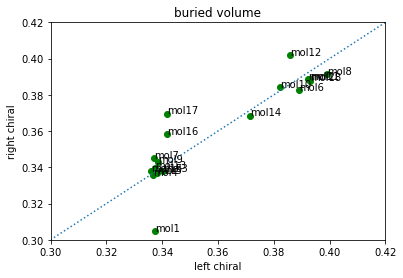

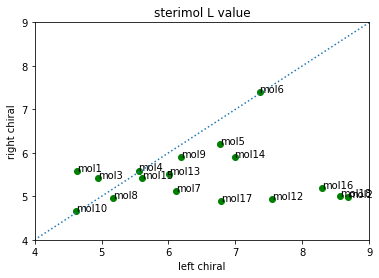

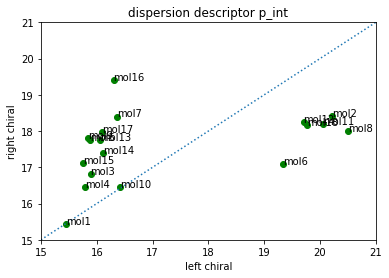

In [60]:
for key in props:
    plt.scatter(props[key][0], props[key][1], c='g', )
    plt.axline([0, 0], [1, 1], linestyle=':')
    plt.xlabel("left chiral")
    plt.ylabel("right chiral")
    plt.title(key)
    if key == "buried volume":
        plt.axis([0.3, 0.42, 0.3, 0.42])
    elif key == "pyramidization":
        plt.axis([0.7, 0.9, 0.7, 0.9])
    elif key == "dispersion descriptor p_int":
        plt.axis([15, 21, 15, 21])
    elif key == "sterimol L value":
        plt.axis([4, 9, 4, 9])
    for i, label in enumerate(labels):
        plt.annotate(label.replace("a", ""), (props[key][0][i], props[key][1][i]))
    plt.show()

## analyzing properties of N atom